<a href="https://colab.research.google.com/github/aim56009/Bias_GAN/blob/master/code/Compute_PSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [10]:
!pip install numpy==1.21.2 
!pip install pysteps==1.3.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from pysteps.utils.spectral import rapsd, corrcoef
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import matplotlib.ticker as ticker


class SpatialSpectralDensity():
    
    def __init__(self):
        
        self.time_period = ('2001', '2014')
        self.num_times = None
        
        self.gan = xr.open_dataset('/content/gdrive/MyDrive/bias_gan/results/gan.nc').gan_precipitation
        self.era5 = xr.open_dataset(f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_W5E5v2.0_regionbox_era5_1979-2014.nc").era5_precipitation*3600*24 
        self.poem = xr.open_dataset(f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_gfdl-esm4_historical_regionbox_1979-2014.nc").precipitation*3600*24 
        
        

        
    def compute_mean_spectral_density(self, data: xr.DataArray):
        
        #data = data.sel(time=slice(self.time_period[0], self.time_period[1]))
        data = data.isel(longitude=slice(0+10,59+10), latitude=slice(0+10,59+10))
        num_frequencies = np.max((len(data.latitude.values),
                                  len(data.longitude.values)))/2
        mean_spectral_density = np.zeros(int(num_frequencies))
        if self.num_times is None:
            num_times = int(len(data.time))
            
        elif self.timestamp is not None:
            num_times = 1
            
        else:
            num_times = self.num_times
        
        for t in range(num_times):
            if self.timestamp is not None:
                tmp = data.sel(time=self.timestamp).values
            else:
                tmp = data.isel(time=t).values
            psd, freq = rapsd(tmp, return_freq=True, normalize=True, fft_method=np.fft)
            mean_spectral_density += psd
        mean_spectral_density /= num_times
        
        return mean_spectral_density, freq
    
    
    def run(self, num_times=None, timestamp=None):
        
        self.num_times = num_times
        self.timestamp = timestamp
        self.gan_psd, self.freq = self.compute_mean_spectral_density(self.gan)
        self.era5_psd, self.freq = self.compute_mean_spectral_density(self.era5)
        self.poem_psd, self.freq = self.compute_mean_spectral_density(self.poem)
        #self.cmip_psd, self.freq = self.compute_mean_spectral_density(self.cmip)
        #self.quantile_mapping_psd, self.freq = self.compute_mean_spectral_density(self.quantile_mapping)
        
        
    def plot(self, axis=None, fname=None, fontsize=None, linewidth=None):
        

        if axis is None: 
            _, ax = plt.subplots(figsize=(7,6))
        else:
            ax = axis

        plt.rcParams.update({'font.size': 12})
        x_vals = 1/self.freq*3.75*111/2
        ax.plot(x_vals, self.era5_psd, label='ERA5', color='k', linewidth=linewidth)
        ax.plot(x_vals, self.poem_psd, label='CM2Mc-LPJmL', color='r', linewidth=linewidth)
        #ax.plot(x_vals, self.cmip_psd, label='GFDL-ESM4', color='b', linewidth=linewidth)
        #ax.plot(x_vals, self.quantile_mapping_psd, label='Quantile mapping', color='m', linewidth=linewidth)
        ax.plot(x_vals, self.gan_psd, label='GAN', color='c', linewidth=linewidth)
        ax.legend(loc='lower left', fontsize=fontsize)
        ax.set_xlim(x_vals[1]+1024, x_vals[-1]-32)
        ax.set_yscale('log', basey=2)
        ax.set_xscale('log', basex=2)
        ax.set_xticks([2**9, 2**10, 2**11, 2**12, 2**13])
        ax.tick_params(axis='x', labelsize=fontsize)
        ax.tick_params(axis='y', labelsize=fontsize)
        ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
        ax.grid()
        ax.set_ylim(4.5e-5, 0.07)
        ax.set_xlabel(r'k [km]', fontsize=fontsize)
        ax.set_ylabel('PSD [a.u]', fontsize=fontsize)
        
        if fname is not None:
            plt.savefig(fname, format='pdf', bbox_inches='tight')

/content/gdrive/MyDrive/bias_gan/results/poem_gan_psd.pdf


"\nplot = PlotAnalysis(plot_data)\n\nfname = f'/results/poem_gan_single_frame.pdf' \n\nplot.single_frames(cmap='YlGnBu', time_index=-7, mask=True)\nplt.rcParams.update({'font.size': 12})\nplt.savefig(fname, format='pdf', bbox_inches='tight')\nplt.show()\nprint(fname)\n"

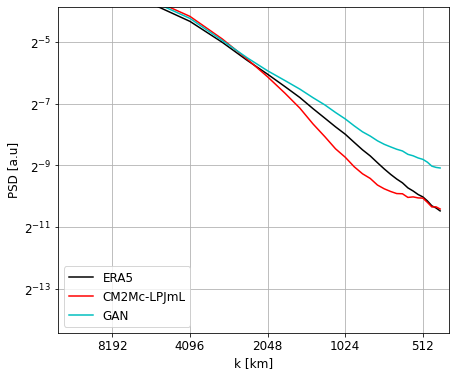

In [13]:
#from Bias_GAN.code.src.spectral_density import SpatialSpectralDensity
ssd = SpatialSpectralDensity()
ssd.run(num_times=None)


fname = f'/content/gdrive/MyDrive/bias_gan/results/poem_gan_psd.pdf' 
ssd.plot(fname=fname)
print(fname)

